In [37]:
%matplotlib inline
%matplotlib widget
import pandas as pd
import matplotlib.pyplot as mpl
import numpy as np
import scipy.stats as st
import calendar
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

from ipywidgets import interact
import ipywidgets as widgets


import seaborn as sns

import geopandas as gpd
import contextily as ctx
from descartes import PolygonPatch
from shapely import wkt


new_cases_df = pd.read_csv("Assignment 2_datasets\Assignment 2_datasets/1.COVID-19_daily_number_of_new_cases_and_deaths.csv", sep=",")
vaccination_df = pd.read_csv("Assignment 2_datasets/Assignment 2_datasets/2.COVID-19_vaccination.csv", sep=",")
icu_df = pd.read_csv("Assignment 2_datasets\Assignment 2_datasets/3.COVID-19_hospital_and_ICU_admission_rates.csv", sep=",")

# Cleaning process new_cases_df
- get rid of unessesary data
- drop duplicates
- missing values
    - Checked for NaN rows in each column individually
    - cases and deaths are the only columns with missing values in new_case_df
- check that colunms are consistent/formating
- outliers
    Due to some contries compenstaing for reporting to high with negative values another day we can't detect outliers.



In [38]:
display(new_cases_df)

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2020,continentExp
0,23/10/2022,23,10,2022,3557.0,0.0,Austria,AT,AUT,8901064,Europe
1,22/10/2022,22,10,2022,5494.0,4.0,Austria,AT,AUT,8901064,Europe
2,21/10/2022,21,10,2022,7776.0,4.0,Austria,AT,AUT,8901064,Europe
3,20/10/2022,20,10,2022,8221.0,6.0,Austria,AT,AUT,8901064,Europe
4,19/10/2022,19,10,2022,10007.0,8.0,Austria,AT,AUT,8901064,Europe
...,...,...,...,...,...,...,...,...,...,...,...
28724,08/02/2020,8,2,2020,0.0,0.0,Sweden,SE,SWE,10327589,Europe
28725,07/02/2020,7,2,2020,0.0,0.0,Sweden,SE,SWE,10327589,Europe
28726,06/02/2020,6,2,2020,0.0,0.0,Sweden,SE,SWE,10327589,Europe
28727,05/02/2020,5,2,2020,0.0,0.0,Sweden,SE,SWE,10327589,Europe


In [39]:
new_cases_df = new_cases_df.loc[new_cases_df["countriesAndTerritories"] != "Liechtenstein"]


new_cases_df.drop_duplicates()

def repair_by_month(column):
    grouped_df = new_cases_df.groupby(['countriesAndTerritories','year','month']) #group by month, year and country
    for name,group in grouped_df: #for each group
        country = name[0] #get month
        year = name[1] #get year
        month = name[2] #get country

        try:
            moast_frequent = group[column].value_counts().idxmax() #get the most frequent value
        except ValueError:
            print(country,month,year) #print the country, month and year of the error
            moast_frequent = 0 #set the most frequent value to 0
        new_cases_df.loc[(new_cases_df['countriesAndTerritories'] == country) & (new_cases_df['month'] == month) & (new_cases_df['year'] == year), column] = new_cases_df.loc[(new_cases_df['countriesAndTerritories'] == country) & (new_cases_df['month'] == month) & (new_cases_df['year'] == year), column].fillna(moast_frequent)

repair_by_month("deaths") #repair the deaths column
repair_by_month("cases") #repair the cases column


Iceland 2 2020
Norway 2 2020


In [40]:
def repair_dates_formatting():
    for index,row in new_cases_df.iterrows():
        new_cases_df.loc[index, "dateRep"] = datetime.datetime(new_cases_df.loc[index, "year"], new_cases_df.loc[index, "month"], new_cases_df.loc[index, "day"]).date()
repair_dates_formatting()

#### Formating columns with floats to int

In [41]:
new_cases_df['cases'] = new_cases_df['cases'].astype(int)
new_cases_df['deaths'] = new_cases_df['deaths'].astype(int)

# Now you can use the modified 'cases' and 'deaths' columns in the original DataFrame
new_cases_df.loc[:, ['cases', 'deaths']] = new_cases_df[['cases', 'deaths']].values.copy()

# Verify the updated DataFrame
display(new_cases_df)

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2020,continentExp
0,2022-10-23,23,10,2022,3557,0,Austria,AT,AUT,8901064,Europe
1,2022-10-22,22,10,2022,5494,4,Austria,AT,AUT,8901064,Europe
2,2022-10-21,21,10,2022,7776,4,Austria,AT,AUT,8901064,Europe
3,2022-10-20,20,10,2022,8221,6,Austria,AT,AUT,8901064,Europe
4,2022-10-19,19,10,2022,10007,8,Austria,AT,AUT,8901064,Europe
...,...,...,...,...,...,...,...,...,...,...,...
28724,2020-02-08,8,2,2020,0,0,Sweden,SE,SWE,10327589,Europe
28725,2020-02-07,7,2,2020,0,0,Sweden,SE,SWE,10327589,Europe
28726,2020-02-06,6,2,2020,0,0,Sweden,SE,SWE,10327589,Europe
28727,2020-02-05,5,2,2020,0,0,Sweden,SE,SWE,10327589,Europe


### From the block below we can see that there are no outliars in the popData2020 column because there's only one unique value for each country.

In [42]:
import scipy.stats as st

# Gets all unique values for the population by country
population_per_country = new_cases_df.groupby("countriesAndTerritories")["popData2020"].unique()

population_per_country

countriesAndTerritories
Austria         [8901064]
Belgium        [11522440]
Bulgaria        [6951482]
Croatia         [4058165]
Cyprus           [888005]
Czechia        [10693939]
Denmark         [5822763]
Estonia         [1328976]
Finland         [5525292]
France         [67320216]
Germany        [83166711]
Greece         [10718565]
Hungary         [9769526]
Iceland          [364134]
Ireland         [4964440]
Italy          [59641488]
Latvia          [1907675]
Lithuania       [2794090]
Luxembourg       [626108]
Malta            [514564]
Netherlands    [17407585]
Norway          [5367580]
Poland         [37958138]
Portugal       [10295909]
Romania        [19328838]
Slovakia        [5457873]
Slovenia        [2095861]
Spain          [47332614]
Sweden         [10327589]
Name: popData2020, dtype: object

In [43]:

grouped_df = new_cases_df.groupby(['countriesAndTerritories','year', 'month'])

is_normal = True

for info, groupby in grouped_df:
    country = info[0] #get country
    year = info[1] #get year
    month = info[2] #get month

    groupby = groupby.loc[(groupby['countriesAndTerritories'] == country) & (groupby['month'] == month) & (groupby['year'] == year)]

    # print(country, month, year)
    if len(groupby['deaths']) > 3:
            if groupby['deaths'].nunique() > 1:  # Check for non-zero range
                stat, p_value = st.shapiro(groupby['deaths'])
                if p_value < 0.05:
                    is_normal = False
                    print(f"Data for {country} is not normal")
            else:
                is_normal = False
                print(f"Data for {country} has zero range")
    else:
        print("Not enough data")

print(f"There is normal distribution: {is_normal}")




Data for Austria has zero range
Data for Austria is not normal
Data for Austria is not normal
Data for Austria is not normal
Data for Austria is not normal
Data for Austria is not normal
Data for Austria is not normal
Data for Austria is not normal
Data for Austria is not normal
Data for Austria is not normal
Data for Austria is not normal
Data for Austria is not normal
Data for Austria is not normal
Data for Austria is not normal
Data for Austria is not normal
Data for Austria is not normal
Data for Austria is not normal
Data for Austria is not normal
Data for Belgium is not normal
Data for Belgium is not normal
Data for Belgium is not normal
Data for Belgium is not normal
Data for Belgium is not normal
Data for Belgium is not normal
Data for Belgium is not normal
Data for Belgium is not normal
Data for Belgium is not normal
Data for Belgium is not normal
Data for Belgium is not normal
Data for Belgium is not normal
Data for Bulgaria is not normal
Data for Bulgaria is not normal
Data 

# Cleaning  COVID-19 vaccinations Dataset

46% missing data in denominator column, and because the questions doen't require comperasions agains specific age-groups we decided to remove it alltogether

In [44]:
missingvalues = vaccination_df["FirstDoseRefused"].isna().sum()/len(vaccination_df["FirstDoseRefused"])
print(f"Percentage of missing values in FirstDoseRefused: {round(missingvalues,4)*100}%")

missingvaluesdenominator = vaccination_df["Denominator"].isna().sum()/len(vaccination_df["Denominator"])
print(f"Percentage of missing values in Denominator: {round(missingvaluesdenominator,4)*100}%")

Percentage of missing values in FirstDoseRefused: 99.79%
Percentage of missing values in Denominator: 46.93%


In [45]:
vaccination_df.drop_duplicates()
vaccination_df["NumberDosesReceived"] = vaccination_df["NumberDosesReceived"].fillna(0) #fill the missing values with 0
vaccination_df["NumberDosesExported"] = vaccination_df["NumberDosesExported"].fillna(0) #fill the missing values with 0
vaccination_df.drop(columns=['FirstDoseRefused'], inplace=True) #removes the column since it has 99.78762127016277% missing values
vaccination_df.drop(columns=['Denominator'], inplace=True)  #removes the column since it has 46.934525119985906% missing values

print(vaccination_df.isna().sum())

YearWeekISO            0
ReportingCountry       0
NumberDosesReceived    0
NumberDosesExported    0
FirstDose              0
SecondDose             0
DoseAdditional1        0
DoseAdditional2        0
DoseAdditional3        0
DoseAdditional4        0
DoseAdditional5        0
UnknownDose            0
Region                 0
TargetGroup            0
Vaccine                0
Population             0
dtype: int64


## Cleaning 3rd dataset
Theres no values in the url column, therefore we'll remove it completly

In [46]:
icu_df = icu_df.drop_duplicates()
icu_df = icu_df.drop(columns=['url'], axis=1)
icu_df.isna().sum()  


country      0
indicator    0
date         0
year_week    0
value        0
source       0
dtype: int64

In [47]:
icu_df.groupby(["indicator"]).count() #Daily metric is most common indicator, therefore we will convert all other indicators to daily metric

,country,date,year_week,value,source
indicator,,,,,
Daily ICU occupancy,8842,8842,8842,8842,8842
Daily hospital occupancy,10984,10984,10984,10984,10984
Weekly new ICU admissions per 100k,2358,2358,2358,2358,2358
Weekly new hospital admissions per 100k,2916,2916,2916,2916,2916


Extracts weekly data from indicator and value columns and then converts it to daily data by dividing by 7 and changing the indicator name

In [48]:
mask = icu_df["indicator"].isin(["Weekly new ICU admissions per 100k", "Weekly new hospital admissions per 100k"]) #mask for weekly indicators
icu_df.loc[mask, 'value'] = (icu_df.loc[mask, 'value'] / 7) #convert weekly indicators to daily indicators

icu_df['indicator'] = icu_df['indicator'].replace({
    "Weekly new ICU admissions per 100k": "Daily new ICU admissions per 100k",
    "Weekly new hospital admissions per 100k": "Daily new hospital admissions per 100k",
    "Daily hospital occupancy": "Daily hospital occupancy per 100k",
    "Daily ICU occupancy": "Daily ICU occupancy per 100k" 
}) #replace weekly indicators with daily indicators

icu_df.to_csv("icu_df.csv", index=True)

# Questions:

# Q1: 
Since 2020 till 2022, which top-10 countries reported the most number of
cases of COVID-19 in quarters per year (Q1-Q4 in each year)? Do you find
these numbers relatively high compared to the country’s population? Do
you see any connection among these countries regarding their geographical locations and the period that most cases are observed? Discuss your
observations

In [49]:
new_cases_df["dateRep"] = pd.to_datetime(new_cases_df["dateRep"],infer_datetime_format=True) #convert dateRep to datetime

new_cases_df["Period"] = new_cases_df["dateRep"].dt.to_period('Q') #add a column with the quarter
new_cases_grouped_Q = new_cases_df.groupby("Period").apply(lambda x: x.groupby("countriesAndTerritories").agg({"cases": "sum", "deaths": "sum", "popData2020": "first"}).sort_values("cases", ascending=False).head(10)) #group by quarter and country and sum the cases and deaths
new_cases_grouped_Q["Percentage"] = round((new_cases_grouped_Q["cases"]/new_cases_grouped_Q["popData2020"])*100,3) #add a column with the percentage of cases per country
new_cases_grouped_Q = new_cases_grouped_Q.reset_index() #reset the index
display(new_cases_grouped_Q)
new_cases_grouped_Q.to_csv("output.csv", index=True)

,Period,countriesAndTerritories,cases,deaths,popData2020,Percentage
0,2020Q1,Spain,167645,10389,47332614,0.354
1,2020Q1,Italy,105792,12428,59641488,0.177
2,2020Q1,Germany,74061,2683,83166711,0.089
3,2020Q1,France,52128,3523,67320216,0.077
4,2020Q1,Belgium,16977,1420,11522440,0.147
...,...,...,...,...,...,...
115,2022Q4,Spain,65031,294,47332614,0.137
116,2022Q4,Netherlands,63860,121,17407585,0.367
117,2022Q4,Belgium,55667,200,11522440,0.483
118,2022Q4,Hungary,47371,435,9769526,0.485


In [50]:
# Load the world dataset
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

europe = world[(world.continent == 'Europe')] #filter out europe to only use it for the map
filtered_europe = europe[~europe.name.isin(['Russia'])] #remove Russia since it is not in the dataset

#Removing France overseas terretories by editiing the polygons
geometry = wkt.loads('MULTIPOLYGON (((6.186320428094177 49.463802802114515, 6.658229607783568 49.20195831969157, 8.099278598674744 49.01778351500333, 7.593676385131062 48.33301911070372, 7.466759067422231 47.62058197691181, 7.192202182655507 47.44976552997102, 6.736571079138059 47.541801255882845, 6.768713820023606 47.2877082383037, 6.037388950229001 46.725778713561866, 6.022609490593538 46.27298981382047, 6.5000997249704255 46.42967275652944, 6.843592970414505 45.99114655210061, 6.802355177445605 45.70857982032864, 7.096652459347837 45.33309886329589, 6.749955275101655 45.02851797136758, 7.007562290076635 44.25476675066136, 7.549596388386107 44.12790110938481, 7.435184767291872 43.69384491634922, 6.52924523278304 43.128892320318315, 4.556962517931424 43.399650987311595, 3.1004105973526634 43.075200507167054, 2.9859989762584576 42.47301504166986, 1.8267932470871528 42.34338471126569, 0.7015906103638941 42.795734361332606, 0.3380469091905809 42.57954600683955, -1.502770961910528 43.03401439063043, -1.901351284177764 43.42280202897834, -1.384225226232985 44.022610378590116, -1.1937975732374184 46.01491771095486, -2.2257242496738456 47.06436269793822, -2.9632761295596026 47.57032664650795, -4.4915549381594815 47.954954332056374, -4.592349819344776 48.68416046812699, -3.295813971357802 48.90169240985963, -1.6165107893849608 48.64442129169454, -1.933494025063311 49.776341864615745, -0.98946895995536 49.34737580016091, 1.3387610205226963 50.12717316344526, 1.6390010921384996 50.9466063502975, 2.5135730322461427 51.14850617126183, 2.658422071960274 50.796848049515745, 3.1232515804256877 50.78036326761455, 3.588184441755658 50.37899241800356, 4.2860229834250845 49.907496649772554, 4.799221632515724 49.98537303323637, 5.674051954784829 49.529483547557504, 5.897759230176348 49.44266714130711, 6.186320428094177 49.463802802114515)), ((8.746009148807559 42.62812185319392, 9.390000848028876 43.00998484961471, 9.560016310269134 42.15249197037952, 9.229752231491773 41.380006822264455, 8.775723097375362 41.58361196549443, 8.544212680707773 42.25651662858306, 8.746009148807559 42.62812185319392)))')
filtered_europe.loc[filtered_europe["name"] == "France", "geometry"] = geometry

color_palette = cm.get_cmap('YlOrBr') #create a color palette"
norm = Normalize(vmin=0, vmax=40)


def erase_plot():
    ax.clear()

def cases_map(x):
    ax = None

    if ax is not None:
        erase_plot()

    countries_list = list(new_cases_grouped_Q.iloc[x:(x+10)]["countriesAndTerritories"]) #get the top 10 countries with the most cases
    cases_countries = filtered_europe[filtered_europe['name'].isin(countries_list)]

    cases_countries_merged = cases_countries.merge(new_cases_grouped_Q.iloc[x:(x+10)][["countriesAndTerritories","Percentage"]], left_on=["name"], right_on="countriesAndTerritories", how="inner")

    ax = filtered_europe.plot(figsize=(8,6),edgecolor='gray', color="White")
    cases_countries_merged.plot(ax=ax, edgecolor='gray', column="Percentage", cmap=color_palette, norm=norm)
    
    plt.ylabel('Latitude')
    plt.xlabel('Longitude')
    
    sm = ScalarMappable(cmap=color_palette, norm=norm)
    sm.set_array([])  # Set an empty array for the colorbar
    
    plt.colorbar(sm)
    
    plt.show()


interact(cases_map, x=widgets.Dropdown(options=[('2020Q1', 0),('2020Q2', 10),('2020Q3', 20),('2020Q4', 30),('2021Q1', 40),('2021Q2', 50),('2021Q3', 60),('2021Q4', 70),('2022Q1', 80),('2022Q2', 90),('2022Q3', 100),('2022Q4', 110)],description='Quarter:'))

NameError: name 'cm' is not defined

# Q3

,YearWeekISO,ReportingCountry,NumberDosesReceived,NumberDosesExported,FirstDose,SecondDose,DoseAdditional1,DoseAdditional2,DoseAdditional3,DoseAdditional4,DoseAdditional5,UnknownDose,Region,TargetGroup,Vaccine,Population
0,2021-W05,AT,0.0,0.0,0,0,0,0,0,0,0,0,AT,Age10_14,AZ,8932664
1,2023-W10,AT,0.0,0.0,0,1,0,0,0,0,0,0,AT,Age<18,NVXD,8978929
2,2023-W10,AT,0.0,0.0,1,0,0,1,0,0,0,0,AT,Age60_69,NVXD,8978929
3,2023-W10,AT,0.0,0.0,0,0,0,0,0,0,0,0,AT,Age15_17,MODBA.1,8978929
4,2023-W10,AT,0.0,0.0,3,1,4,80,53,0,0,0,AT,ALL,MOD,8978929
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
681325,2021-W25,SK,0.0,0.0,2,0,0,0,0,0,0,0,SK,AgeUNK,MOD,5459781
681326,2021-W25,SK,0.0,0.0,3665,0,0,0,0,0,0,0,SK,ALL,SPU,5459781
681327,2021-W25,SK,0.0,0.0,1,0,0,0,0,0,0,0,SK,Age15_17,SPU,5459781
681328,2021-W25,SK,0.0,0.0,99,0,0,0,0,0,0,0,SK,Age18_24,SPU,5459781


ReportingCountry           AT
Vaccine                   COM
TotalVaccinations    31683798
Name: 1, dtype: object
[[['AT', 'COM', 31683798], ['AT', 'MOD', 3297760], ['AT', 'AZ', 3186482]], [['BE', 'COM', 36162129], ['BE', 'MOD', 8842371], ['BE', 'COMBA.1', 6242886]], [['BG', 'COM', 6284625], ['BG', 'JANSS', 1072170], ['BG', 'MOD', 1041918]], [['CY', 'COM', 2656134], ['CY', 'AZ', 544840], ['CY', 'MOD', 402148]], [['CZ', 'COM', 31381663], ['CZ', 'MOD', 3409439], ['CZ', 'AZ', 1823018]], [['DE', 'UNK', 376121604]], [['DK', 'COM', 22353849], ['DK', 'MOD', 3685055], ['DK', 'COMBA.4-5', 2485550]], [['EE', 'COM', 3150919], ['EE', 'AZ', 479688], ['EE', 'MOD', 479022]], [['EL', 'COM', 53227188], ['EL', 'MOD', 4902262], ['EL', 'AZ', 4678694]], [['ES', 'COM', 139283842], ['ES', 'MOD', 49706777], ['ES', 'AZ', 20263804]], [['FI', 'COM', 61563626], ['FI', 'MOD', 12387274], ['FI', 'UNK', 5306720]], [['FR', 'UNK', 480659195], ['FR', 'COM', 110754723], ['FR', 'MOD', 24822205]], [['HR', 'COM', 8223051], [

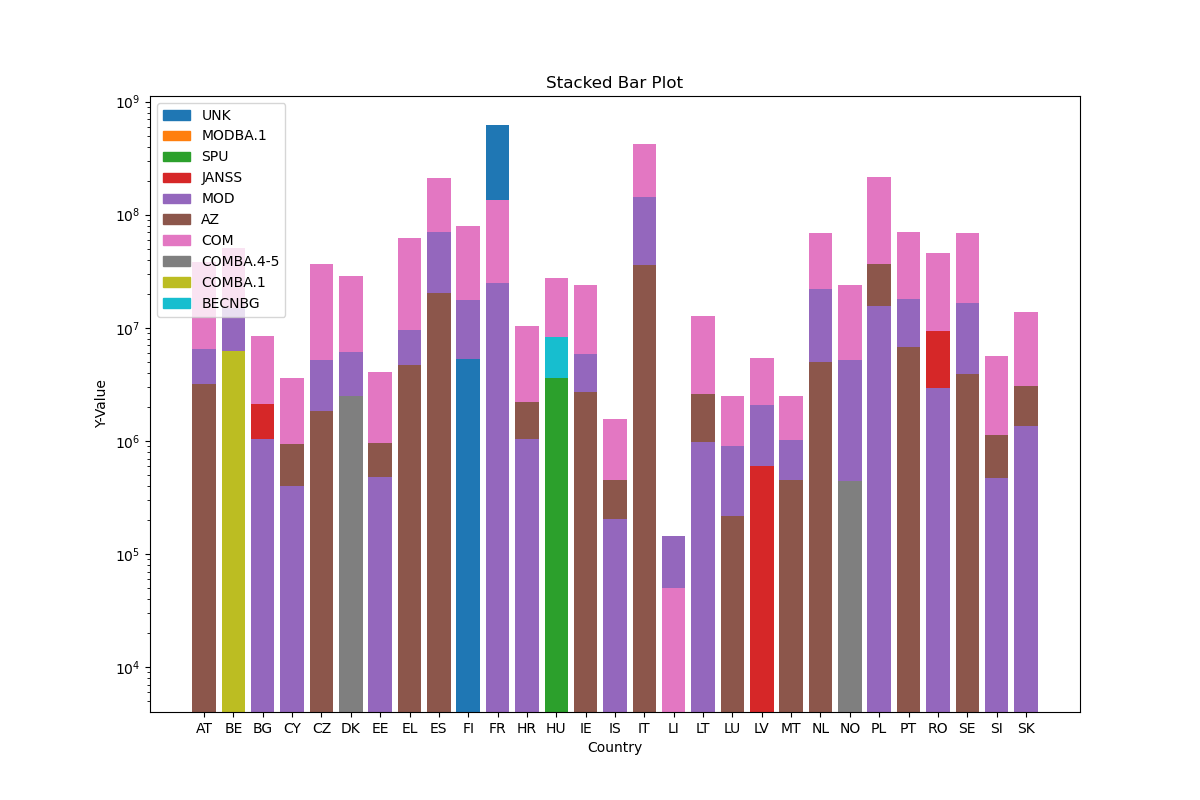

In [51]:
vaccination_count_per_country = vaccination_df.groupby(["ReportingCountry", "Vaccine"]).sum()
vaccination_count_per_country['TotalVaccinations'] = vaccination_count_per_country[['FirstDose', 'SecondDose', 'DoseAdditional1', 'DoseAdditional2', 'DoseAdditional3', 'DoseAdditional4', 'DoseAdditional5', 'UnknownDose']].sum(axis=1)
# display(vaccination_count_per_country)

summary_data = vaccination_count_per_country.groupby(['ReportingCountry','Vaccine'])['TotalVaccinations'].sum().reset_index()
total_vaccine_data_sum = summary_data.groupby(['Vaccine'])['TotalVaccinations'].sum().reset_index().sort_values(by=['TotalVaccinations'], ascending=False)
top_3_vaccines_total = total_vaccine_data_sum.nlargest(3, 'TotalVaccinations')
sorted_summary_data = summary_data.sort_values(by=['ReportingCountry','TotalVaccinations'], ascending=[True, False])
top_3_vaccines_per_country = sorted_summary_data.groupby(['ReportingCountry']).head(3)
display(vaccination_df)



print(top_3_vaccines_per_country.iloc[0]) 
country_nested_list = []
for country in top_3_vaccines_per_country['ReportingCountry'].unique():
    nested_list = []
    country_data = top_3_vaccines_per_country[top_3_vaccines_per_country['ReportingCountry'] == country]
    nested_list = country_data.values.tolist()
    country_nested_list.append(nested_list)

print(country_nested_list)

x_values = []
y_values = []
legend_values = []

for nested_list in country_nested_list:
    if len(nested_list) >= 3:
        x_values.append(nested_list[0][0])
        y_values.append([nested_list[0][2], nested_list[1][2], nested_list[2][2]])
        legend_values.extend([nested_list[0][1], nested_list[1][1], nested_list[2][1]])

indices = np.arange(len(x_values))

plt.figure(figsize=(12, 8))

# Get unique legend values and their corresponding colors
unique_legend_values = list(set(legend_values))
colors = plt.cm.get_cmap('tab10', len(unique_legend_values))

# Reverse the order of y_values
y_values = [y[::-1] for y in y_values]

# Plot the stacked bars with the corresponding colors
bottom = np.zeros_like(indices)
for i, y_vals in enumerate(y_values):
    for j, y_val in enumerate(y_vals):
        plt.bar(indices[i], y_val, bottom=bottom[i], color=colors(unique_legend_values.index(legend_values[(i*3)+(2-j)])))
        bottom[i] += y_val

plt.yscale('log')
plt.xticks(indices, x_values)
plt.xlabel('Country')
plt.ylabel('Y-Value')
plt.title('Stacked Bar Plot')

# Create a dictionary for legend labels
legend_labels = {value: value for value in unique_legend_values}

# Create a custom legend with unique labels and corresponding colors
custom_legend = []
for val in unique_legend_values:
    if val in legend_labels:
        custom_legend.append(plt.Rectangle((0, 0), 1, 1, color=colors(unique_legend_values.index(val))))
        del legend_labels[val]

plt.legend(custom_legend, unique_legend_values)
plt.show()

# Q4

In [80]:
# Get the top 3 vaccine names for each country
top_3_vaccine_names = top_3_vaccines_per_country.groupby('ReportingCountry')['Vaccine'].apply(list).reset_index()

# Iterate over each country
for _, row in top_3_vaccine_names.iterrows():
    country = row['ReportingCountry']
    vaccines = row['Vaccine']

    # Filter the vaccine_df for the country and the top 3 vaccines
    filtered_df = vaccination_df[(vaccination_df['ReportingCountry'] == country) & (vaccination_df['Vaccine'].isin(vaccines))]

    # Group by Vaccine and TargetGroup and calculate the sum of doses
    group_df = filtered_df.groupby(['Vaccine', 'TargetGroup']).sum().reset_index()

    # Find the TargetGroup with the maximum sum of doses for each vaccine
    max_group = group_df.groupby('Vaccine')[['FirstDose', 'SecondDose']].sum().idxmax().reset_index()
    max_vaccine = max_group.loc[0, 0]

    # Filter group_df for the vaccine with the maximum sum of doses
    max_group = group_df[group_df['Vaccine'] == max_vaccine]

    print(f"Country: {country}")
    print(max_group[['Vaccine', 'TargetGroup']])
    # print()


Country: AT
   Vaccine TargetGroup
12     COM         ALL
13     COM      Age0_4
14     COM    Age10_14
15     COM    Age15_17
16     COM    Age18_24
17     COM    Age25_49
18     COM    Age50_59
19     COM      Age5_9
20     COM    Age60_69
21     COM    Age70_79
22     COM      Age80+
23     COM      Age<18
Country: BE
   Vaccine TargetGroup
0      COM         ALL
1      COM    Age18_24
2      COM    Age25_49
3      COM    Age50_59
4      COM    Age60_69
5      COM    Age70_79
6      COM      Age80+
7      COM      Age<18
8      COM      AgeUNK
9      COM         HCW
10     COM        LTCF
Country: BG
   Vaccine TargetGroup
0      COM         ALL
1      COM    Age18_24
2      COM    Age25_49
3      COM    Age50_59
4      COM    Age60_69
5      COM    Age70_79
6      COM      Age80+
7      COM      Age<18
8      COM      AgeUNK
9      COM         HCW
10     COM        LTCF
Country: CY
   Vaccine TargetGroup
12     COM         ALL
13     COM      Age0_4
14     COM    Age10_14
15     CO